# Création dataset Demo

In [2]:
import polars as pl
import sys
import os

print("--- Lancement Data Prep (Version Notebook) ---")

# --- 1. DÉFINIR LES CHEMINS (Version Notebook) ---
# On part de /Notebooks/ et on remonte avec "../"
PATH_UL = "../Data/raw/StockUniteLegale_utf8.parquet"
PATH_ETAB = "../Data/raw/StockEtablissement_utf8.parquet"
PATH_ETAB_HISTO = "../Data/raw/StockEtablissementHistorique_utf8.parquet"
PATH_OUTPUT = "../Data/processed/sirene_infos_MONSTROUS_DEMO.parquet" # C'est notre nouveau "Master File"

print("--- Lancement Script 01: Création du MASTER FILE 'Démo Monstrueuse' ---")

# --- 2. VÉRIFICATION DES FICHIERS ---
for path in [PATH_UL, PATH_ETAB, PATH_ETAB_HISTO]:
    if not os.path.exists(path):
        print(f"ERREUR FATALE: Fichier brut manquant : {path}", file=sys.stderr)
        print("Vérifie que tes 3 fichiers SIRENE sont bien dans '../Data/raw/'")
        raise FileNotFoundError(f"Fichier non trouvé : {path}")
print("Fichiers bruts trouvés. Lancement de la pipeline...")

# ===================================================================
# ÉTAPE 1: La Base (FEATURES X) - Fichier 'StockUniteLegale'
# (On prend 8 features au lieu de 5)
# ===================================================================
print("Étape 1: Lecture des features de 'StockUniteLegale'...")
df_base_features = pl.scan_parquet(PATH_UL).select(
    "siren",
    "dateCreationUniteLegale",
    "categorieJuridiqueUniteLegale",
    "trancheEffectifsUniteLegale",
    "activitePrincipaleUniteLegale",
    "categorieEntreprise",                 # <-- AJOUTÉ
    "economieSocialeSolidaireUniteLegale", # <-- AJOUTÉ
    "societeMissionUniteLegale"            # <-- AJOUTÉ
)

# ===================================================================
# ÉTAPE 2: Trouver le SIRET du Siège (HQ) - Fichier 'StockEtablissement'
# (On prend 3 features au lieu d'une)
# ===================================================================
print("Étape 2: Lecture de 'StockEtablissement' pour trouver les sièges...")
df_sieges = pl.scan_parquet(PATH_ETAB).filter(
    pl.col("etablissementSiege") == True
).select(
    "siren", 
    "siret",
    pl.col("codePostalEtablissement").str.slice(0, 2).alias("departement"),
    pl.col("trancheEffectifsEtablissement").alias("trancheEffectifsSiege"), # <-- NOUVELLE FEATURE
    pl.col("caractereEmployeurEtablissement").alias("caractereEmployeurSiege") # <-- NOUVELLE FEATURE
)

# ===================================================================
# ÉTAPE 3: Trouver la Date de Fermeture (La Cible Y) 
# - Fichier 'StockEtablissementHistorique'
# ===================================================================
print("Étape 3: Lecture de 'StockEtablissementHistorique' pour trouver les 'morts'...")
df_fermetures = pl.scan_parquet(PATH_ETAB_HISTO).filter(
    pl.col("etatAdministratifEtablissement") == 'F'
).select(
    "siret",
    pl.col("dateFin").alias("dateFermeture")
).group_by("siret").agg(
    pl.col("dateFermeture").max() 
)

# ===================================================================
# ÉTAPE 4: Le "Grand Mariage" SIRENE
# (Rien ne change ici)
# ===================================================================
print("Étape 4: Jointure finale des 3 tables...")
# On utilise .collect() ici pour forcer la 1ère jointure
df_master = df_base_features.collect().join(
    df_sieges.collect(), on="siren", how="left"
)
# On joint le 2e
df_master = df_master.join(
    df_fermetures.collect(), on="siret", how="left"
)

# ===================================================================
# ÉTAPE 5: Sauvegarde
# (On a maintenant 14 colonnes "propres" !)
# ===================================================================
print(f"Sauvegarde du Master File 'Démo Monstrueuse' dans {PATH_OUTPUT}...")
df_final = df_master.select(
    # Les Clés (pour la Target)
    "siren",
    "dateCreationUniteLegale",
    "dateFermeture",
    # Les 12 Features "Monstrueuses"
    "categorieJuridiqueUniteLegale",
    "trancheEffectifsUniteLegale",
    "activitePrincipaleUniteLegale",
    "categorieEntreprise",
    "economieSocialeSolidaireUniteLegale",
    # "societeMissionUniteLegale",
    # "sexeUniteLegale", # On l'enlève, il est souvent 'null'
    pl.col("dateCreationUniteLegale").dt.year().alias("anneeCreation"),
    pl.col("dateCreationUniteLegale").dt.month().alias("moisCreation"),
    "departement",
    "trancheEffectifsSiege",
    "caractereEmployeurSiege"
)

# On s'assure que le dossier 'processed' existe
os.makedirs(os.path.dirname(PATH_OUTPUT), exist_ok=True)

# On sauvegarde
df_final.write_parquet(PATH_OUTPUT)
print(f"--- Script 01 (Démo Monstrueuse) Terminé avec Succès ---")
print(f"Fichier créé : {PATH_OUTPUT}")
print(f"Shape finale : {df_final.shape}")
print(df_final.head())

--- Lancement Data Prep (Version Notebook) ---
--- Lancement Script 01: Création du MASTER FILE 'Démo Monstrueuse' ---
Fichiers bruts trouvés. Lancement de la pipeline...
Étape 1: Lecture des features de 'StockUniteLegale'...
Étape 2: Lecture de 'StockEtablissement' pour trouver les sièges...
Étape 3: Lecture de 'StockEtablissementHistorique' pour trouver les 'morts'...
Étape 4: Jointure finale des 3 tables...
Sauvegarde du Master File 'Démo Monstrueuse' dans ../Data/processed/sirene_infos_MONSTROUS_DEMO.parquet...
--- Script 01 (Démo Monstrueuse) Terminé avec Succès ---
Fichier créé : ../Data/processed/sirene_infos_MONSTROUS_DEMO.parquet
Shape finale : (28882409, 13)
shape: (5, 13)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ siren     ┆ dateCreat ┆ dateFerme ┆ categorie ┆ … ┆ moisCreat ┆ departeme ┆ trancheEf ┆ caracter │
│ ---       ┆ ionUniteL ┆ ture      ┆ Juridique ┆   ┆ ion       ┆ nt        ┆ fectifsSi ┆ eEmploye │
│ str

In [3]:
df_final.describe()

statistic,siren,dateCreationUniteLegale,dateFermeture,categorieJuridiqueUniteLegale,trancheEffectifsUniteLegale,activitePrincipaleUniteLegale,categorieEntreprise,economieSocialeSolidaireUniteLegale,anneeCreation,moisCreation,departement,trancheEffectifsSiege,caractereEmployeurSiege
str,str,str,str,f64,str,str,str,str,f64,f64,str,str,str
"""count""","""28882409""","""27710121""","""1198759""",2.8882409e7,"""28882409""","""28860884""","""10546073""","""6167001""",2.7710121e7,2.7710121e7,"""28560617""","""28860588""","""28707092"""
"""null_count""","""0""","""1172288""","""27683650""",0.0,"""0""","""21525""","""18336336""","""22715408""",1.172288e6,1.172288e6,"""321792""","""21821""","""175317"""
"""mean""",null,"""2005-10-22 13:11:56.004134""","""2010-09-25 00:21:57.306314""",3246.573881,null,null,null,null,2005.370016,5.966385,null,null,null
"""std""",null,null,null,2736.41353,null,null,null,null,18.148138,3.714184,null,null,null
"""min""","""000325175""","""0001-01-16""","""1900-12-31""",1000.0,"""00""","""00.00""","""ETI""","""N""",1.0,1.0,""" D""","""00""","""N"""
"""25%""",null,"""1995-01-19""","""2003-12-24""",1000.0,null,null,null,null,1995.0,2.0,null,null,null
"""50%""",null,"""2010-05-01""","""2010-10-13""",1000.0,null,null,null,null,2010.0,6.0,null,null,null
"""75%""",null,"""2019-11-02""","""2019-12-02""",5599.0,null,null,null,null,2019.0,9.0,null,null,null
"""max""","""999992357""","""3023-01-06""","""5015-04-04""",9970.0,"""NN""","""99.0Z""","""PME""","""O""",3023.0,12.0,"""sw""","""NN""","""O"""


In [4]:
# je veux clean toutes les nulls dans df_final des colonnes departement, dateCreationUniteLegale, activitéPrincipaleUniteLegale, trancheEffectifsUniteLegale

df_clean = df_final.drop_nulls(subset=[
    "departement", 
    "dateCreationUniteLegale", 
    "activitePrincipaleUniteLegale", 
    "trancheEffectifsUniteLegale",
    "categorieEntreprise",
    "caractereEmployeurSiege"
])

In [5]:
# je veux que tu m'enleve toutes les lignes ou la date de fermeture est avant la date de création masi aussi ou la date de fermeture est le même jour que la date de création mais aussi si la date de fermeture est plus tard que la date du jour 

from datetime import datetime
today = datetime.today().date()

df_clean = df_clean.filter(
    ( (pl.col("dateFermeture").is_null()) | 
      (pl.col("dateFermeture") > pl.col("dateCreationUniteLegale")) & 
      (pl.col("dateFermeture") < pl.lit(today)) )
)

In [6]:
# Je veux enlever les entreprises crées avant 1970 et après la date d'ajourd'hui

df_clean = df_clean.filter(
    (pl.col("dateCreationUniteLegale").dt.year() >= 1970) & 
    (pl.col("dateCreationUniteLegale") <= pl.lit(today))
)

In [7]:
df_clean.describe()

statistic,siren,dateCreationUniteLegale,dateFermeture,categorieJuridiqueUniteLegale,trancheEffectifsUniteLegale,activitePrincipaleUniteLegale,categorieEntreprise,economieSocialeSolidaireUniteLegale,anneeCreation,moisCreation,departement,trancheEffectifsSiege,caractereEmployeurSiege
str,str,str,str,f64,str,str,str,str,f64,f64,str,str,str
"""count""","""10223433""","""10223433""","""432318""",1.0223433e7,"""10223433""","""10223433""","""10223433""","""2902459""",1.0223433e7,1.0223433e7,"""10223433""","""10223433""","""10223433"""
"""null_count""","""0""","""0""","""9791115""",0.0,"""0""","""0""","""0""","""7320974""",0.0,0.0,"""0""","""0""","""0"""
"""mean""",null,"""2012-06-08 22:07:57.438449""","""2018-11-30 19:07:51.502921""",3056.154825,null,null,null,null,2011.980528,6.185161,null,null,null
"""std""",null,null,null,2549.956592,null,null,null,null,11.055441,3.593599,null,null,null
"""min""","""000325175""","""1970-01-01""","""1971-04-19""",1000.0,"""00""","""00.00Z""","""ETI""","""N""",1970.0,1.0,""" D""","""00""","""N"""
"""25%""",null,"""2007-05-10""","""2017-01-02""",1000.0,null,null,null,null,2007.0,3.0,null,null,null
"""50%""",null,"""2016-02-01""","""2020-12-31""",1000.0,null,null,null,null,2016.0,6.0,null,null,null
"""75%""",null,"""2021-02-11""","""2022-12-31""",5499.0,null,null,null,null,2021.0,9.0,null,null,null
"""max""","""999992357""","""2025-11-01""","""2025-11-17""",9970.0,"""NN""","""99.00Z""","""PME""","""O""",2025.0,12.0,"""sw""","""NN""","""O"""


In [8]:
df_clean.head()

siren,dateCreationUniteLegale,dateFermeture,categorieJuridiqueUniteLegale,trancheEffectifsUniteLegale,activitePrincipaleUniteLegale,categorieEntreprise,economieSocialeSolidaireUniteLegale,anneeCreation,moisCreation,departement,trancheEffectifsSiege,caractereEmployeurSiege
str,date,date,i64,str,str,str,str,i32,i8,str,str,str
"""000325175""",2000-09-26,null,1000,"""NN""","""32.12Z""","""PME""",null,2000,9,"""13""","""NN""","""N"""
"""005540273""",1972-01-01,null,1000,"""NN""","""68.20B""","""PME""",null,1972,1,"""04""","""NN""","""N"""
"""005541552""",1974-01-01,null,5710,"""02""","""56.10C""","""PME""","""N""",1974,1,"""04""","""01""","""O"""
"""005641154""",1981-02-01,null,1000,"""NN""","""68.31Z""","""PME""",null,1981,2,"""04""","""NN""","""N"""
"""005742580""",1993-03-01,null,1000,"""NN""","""68.20B""","""PME""",null,1993,3,"""04""","""NN""","""N"""


In [9]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. CHARGER LE "MASTER FILE" DÉMO MONSTRUEUX ---
PATH_ML_DEMO = "../Data/processed/sirene_infos_MONSTROUS_DEMO.parquet"
try:
    df_master = pl.read_parquet(PATH_ML_DEMO)
    print(f"Dataset 'Démo Monstrueuse' chargé. Shape: {df_master.shape}")
except FileNotFoundError:
    print(f"ERREUR: Fichier non trouvé : {PATH_ML_DEMO}")
    print("Assure-toi que ton script de Data Prep a bien tourné.")

# --- 2. FILTRER LA COHORTE ---
# On va étudier les entreprises créées en 2018
# print("Filtrage de la Cohorte 2018...")
# df_ml = df_master.filter(
#     pl.col("dateCreationUniteLegale").dt.year() == 2018
# )
# print(f"Cohorte 2018 isolée. Shape: {df_ml.shape}")
df_ml = df_master

# --- 3. CRÉATION DE LA TARGET (Y) ---
print("Création de la Cible (is_failed_in_3y)...")

df_ml = df_ml.with_columns(
    # Date limite = 3 ans après la création
    (pl.col("dateCreationUniteLegale").dt.offset_by("3y")).alias("date_limite_3_ans")
).with_columns(
    # 1 = Faillite si Fermé AVANT la date limite
    pl.when(
        (pl.col("dateFermeture").is_not_null()) & # dateFermeture n'est pas null
        (pl.col("dateFermeture") < pl.col("date_limite_3_ans"))
    ).then(1)
    .otherwise(0)
    .alias("is_failed_in_3y")
).fill_null("INCONNU") # Nettoyage final des features catégorielles

# --- 4. VÉRIFICATION (EDA Rapide) ---
print("--- DATASET ML PRÊT ---")
print(f"Shape finale prête pour le ML : {df_ml.shape}")

# On vérifie la répartition de notre nouvelle Cible
print("\nRépartition de la Cible (Y) :")
print(df_ml.get_column("is_failed_in_3y").value_counts())

print("\nAperçu du DataFrame final :")
print(df_ml.head())

Dataset 'Démo Monstrueuse' chargé. Shape: (28882409, 13)
Création de la Cible (is_failed_in_3y)...
--- DATASET ML PRÊT ---
Shape finale prête pour le ML : (28882409, 15)

Répartition de la Cible (Y) :
shape: (2, 2)
┌─────────────────┬──────────┐
│ is_failed_in_3y ┆ count    │
│ ---             ┆ ---      │
│ i32             ┆ u32      │
╞═════════════════╪══════════╡
│ 1               ┆ 274481   │
│ 0               ┆ 28607928 │
└─────────────────┴──────────┘

Aperçu du DataFrame final :
shape: (5, 15)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ siren     ┆ dateCreat ┆ dateFerme ┆ categorie ┆ … ┆ trancheEf ┆ caractere ┆ date_limi ┆ is_faile │
│ ---       ┆ ionUniteL ┆ ture      ┆ Juridique ┆   ┆ fectifsSi ┆ Employeur ┆ te_3_ans  ┆ d_in_3y  │
│ str       ┆ egale     ┆ ---       ┆ UniteLega ┆   ┆ ege       ┆ Siege     ┆ ---       ┆ ---      │
│           ┆ ---       ┆ date      ┆ le        ┆   ┆ ---       ┆ ---       ┆ date      ┆

In [10]:
df_ml.describe()

statistic,siren,dateCreationUniteLegale,dateFermeture,categorieJuridiqueUniteLegale,trancheEffectifsUniteLegale,activitePrincipaleUniteLegale,categorieEntreprise,economieSocialeSolidaireUniteLegale,anneeCreation,moisCreation,departement,trancheEffectifsSiege,caractereEmployeurSiege,date_limite_3_ans,is_failed_in_3y
str,str,str,str,f64,str,str,str,str,f64,f64,str,str,str,str,f64
"""count""","""28882409""","""27710121""","""1198759""",2.8882409e7,"""28882409""","""28882409""","""28882409""","""28882409""",2.7710121e7,2.7710121e7,"""28882409""","""28882409""","""28882409""","""27710121""",2.8882409e7
"""null_count""","""0""","""1172288""","""27683650""",0.0,"""0""","""0""","""0""","""0""",1.172288e6,1.172288e6,"""0""","""0""","""0""","""1172288""",0.0
"""mean""",null,"""2005-10-22 13:11:56.004134""","""2010-09-25 00:21:57.306314""",3246.573881,null,null,null,null,2005.370016,5.966385,null,null,null,"""2008-10-22 06:59:33.149002""",0.009503
"""std""",null,null,null,2736.41353,null,null,null,null,18.148138,3.714184,null,null,null,null,0.097021
"""min""","""000325175""","""0001-01-16""","""1900-12-31""",1000.0,"""00""","""00.00""","""ETI""","""INCONNU""",1.0,1.0,""" D""","""00""","""INCONNU""","""0004-01-16""",0.0
"""25%""",null,"""1995-01-19""","""2003-12-24""",1000.0,null,null,null,null,1995.0,2.0,null,null,null,"""1998-01-19""",0.0
"""50%""",null,"""2010-05-01""","""2010-10-13""",1000.0,null,null,null,null,2010.0,6.0,null,null,null,"""2013-05-01""",0.0
"""75%""",null,"""2019-11-02""","""2019-12-02""",5599.0,null,null,null,null,2019.0,9.0,null,null,null,"""2022-11-02""",0.0
"""max""","""999992357""","""3023-01-06""","""5015-04-04""",9970.0,"""NN""","""INCONNU""","""PME""","""O""",3023.0,12.0,"""sw""","""NN""","""O""","""3026-01-06""",1.0


In [11]:
# sauvergarde ça dans un parquet

PATH_OUTPUT_CLEAN = "../Data/processed/sirene_infos_CLEAN.parquet"

df_ml.write_parquet(PATH_OUTPUT_CLEAN)


In [12]:
df_ml.schema

Schema([('siren', String),
        ('dateCreationUniteLegale', Date),
        ('dateFermeture', Date),
        ('categorieJuridiqueUniteLegale', Int64),
        ('trancheEffectifsUniteLegale', String),
        ('activitePrincipaleUniteLegale', String),
        ('categorieEntreprise', String),
        ('economieSocialeSolidaireUniteLegale', String),
        ('anneeCreation', Int32),
        ('moisCreation', Int8),
        ('departement', String),
        ('trancheEffectifsSiege', String),
        ('caractereEmployeurSiege', String),
        ('date_limite_3_ans', Date),
        ('is_failed_in_3y', Int32)])

---

# Crétion dataset bilan

In [12]:
import polars as pl
import pyarrow.parquet as pq
import sys

filepath = "../Data/processed/sirene_bilanv0.parquet" 

print("--- Début de la lecture 'bypass' ---")

try:
    print(f"Lecture du fichier via PyArrow : {filepath}")
    table_arrow = pq.read_table(
        filepath,
    )
    
    print("Conversion de la table PyArrow en DataFrame Polars...")
    df_bilan = pl.from_arrow(table_arrow)
    
    print("--- SUCCÈS ! ---\n")
    print("Le DataFrame est maintenant dans Polars, prêt pour la transformation.")
    print(df_bilan.head())

except Exception as e:
    print(f"\n--- ERREUR ---", file=sys.stderr)
    print(f"Impossible de lire le fichier, même avec PyArrow : {e}", file=sys.stderr)

--- Début de la lecture 'bypass' ---
Lecture du fichier via PyArrow : ../Data/processed/sirene_bilanv0.parquet
Conversion de la table PyArrow en DataFrame Polars...
--- SUCCÈS ! ---

Le DataFrame est maintenant dans Polars, prêt pour la transformation.
shape: (5, 21)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ siren     ┆ date_clot ┆ CJCK_Tota ┆ EG_Impots ┆ … ┆ ratio_cap ┆ ratio_tre ┆ ratio_res ┆ ratio_re │
│ ---       ┆ ure_exerc ┆ lActifBru ┆ Taxes     ┆   ┆ itaux_pro ┆ sorerie   ┆ ultat_fin ┆ sultat_e │
│ str       ┆ ice       ┆ t         ┆ ---       ┆   ┆ pres      ┆ ---       ┆ ancier    ┆ xception │
│           ┆ ---       ┆ ---       ┆ i32       ┆   ┆ ---       ┆ f64       ┆ ---       ┆ nel      │
│           ┆ date      ┆ i32       ┆           ┆   ┆ f64       ┆           ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ f64      │
╞═══════════╪═══════════╪

In [13]:
df_bilan.schema

Schema([('siren', String),
        ('date_cloture_exercice', Date),
        ('CJCK_TotalActifBrut', Int32),
        ('EG_ImpotsTaxes', Int32),
        ('FJ_ResultatFinancier', Int32),
        ('FA_ChiffreAffairesVentes', Int32),
        ('HN_RésultatNet', Int32),
        ('DA_TresorerieActive', Int32),
        ('DL_DettesCourtTerme', Int32),
        ('FB_AchatsMarchandises', Int32),
        ('FR_ResultatExceptionnel', Int32),
        ('DF_CapitauxPropres', Int32),
        ('DM_DettesLongTerme', Int32),
        ('AnneeClotureExercice', Int32),
        ('ratio_rentabilite_nette', Float64),
        ('ratio_endettement', Float64),
        ('ratio_marge_brute', Float64),
        ('ratio_capitaux_propres', Float64),
        ('ratio_tresorerie', Float64),
        ('ratio_resultat_financier', Float64),
        ('ratio_resultat_exceptionnel', Float64)])

In [14]:
df_bilan.head(10)

siren,date_cloture_exercice,CJCK_TotalActifBrut,EG_ImpotsTaxes,FJ_ResultatFinancier,FA_ChiffreAffairesVentes,HN_RésultatNet,DA_TresorerieActive,DL_DettesCourtTerme,FB_AchatsMarchandises,FR_ResultatExceptionnel,DF_CapitauxPropres,DM_DettesLongTerme,AnneeClotureExercice,ratio_rentabilite_nette,ratio_endettement,ratio_marge_brute,ratio_capitaux_propres,ratio_tresorerie,ratio_resultat_financier,ratio_resultat_exceptionnel
str,date,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64
"""005420120""",2018-12-31,15117606,841098,135797,4623,-289131,711840,90269342,0,470896,0,0,2018,-62.541856,5.97114,1.0,0.0,0.047087,29.374216,101.859399
"""005420120""",2021-12-31,10813111,2500000,271605,44073,-1974866,711840,86469939,0,619916,0,0,2021,-44.808976,7.996768,1.0,0.0,0.065831,6.162617,14.065664
"""005420120""",2017-12-31,22684824,441247,98112,26192,-376691,711840,90919571,0,450623,0,0,2017,-14.381911,4.007947,1.0,0.0,0.03138,3.745877,17.204604
"""005420120""",2016-12-31,31933093,586967,104225,11836,-261053,711840,92013428,0,781843,0,0,2016,-22.055847,2.881444,1.0,0.0,0.022292,8.805762,66.056353
"""005420120""",2019-12-31,12736527,0,217792,48370,-970147,711840,89288445,0,520363,0,0,2019,-20.056791,7.010423,1.0,0.0,0.05589,4.502626,10.75797
"""005420120""",2020-12-31,12006568,885730,342381,72481,-807683,711840,88446360,0,725921,0,0,2020,-11.143376,7.366498,1.0,0.0,0.059288,4.723734,10.015328
"""005420120""",2022-12-31,10107302,854623,245784,13906,-1081200,711840,85387013,0,526013,0,0,2022,-77.750611,8.448052,1.0,0.0,0.070428,17.674673,37.826334
"""005450119""",2018-12-31,197475,0,0,0,-1429,14178,-285356,0,0,0,0,2018,-1.4290e9,-1.445023,0.0,0.0,0.071796,0.0,0.0
"""005450119""",2015-12-31,198745,1800,0,0,-1559,14178,-281363,0,0,0,0,2015,-1.5590e9,-1.415699,0.0,0.0,0.071338,0.0,0.0


In [15]:
import polars as pl

# 1. Conversion des types (essentiel)
# On retire la conversion de date, car elle est déjà du bon type (Date) d'après le schéma
df_bilan = df_bilan.with_columns(
     #pl.col("date_cloture_exercice").str.strptime(pl.Date, format="%Y-%m-%d"), # <-- ON RETIRE CETTE LIGNE
     pl.col("siren").cast(pl.String) # S'assurer que 'siren' est de type string
)

# 2. Tri par siren et par date
df_sorted = df_bilan.sort(["siren", "date_cloture_exercice"])
df_sorted.head(10)

siren,date_cloture_exercice,CJCK_TotalActifBrut,EG_ImpotsTaxes,FJ_ResultatFinancier,FA_ChiffreAffairesVentes,HN_RésultatNet,DA_TresorerieActive,DL_DettesCourtTerme,FB_AchatsMarchandises,FR_ResultatExceptionnel,DF_CapitauxPropres,DM_DettesLongTerme,AnneeClotureExercice,ratio_rentabilite_nette,ratio_endettement,ratio_marge_brute,ratio_capitaux_propres,ratio_tresorerie,ratio_resultat_financier,ratio_resultat_exceptionnel
str,date,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64
"""005420120""",2016-12-31,31933093,586967,104225,11836,-261053,711840,92013428,0,781843,0,0,2016,-22.055847,2.881444,1.0,0.0,0.022292,8.805762,66.056353
"""005420120""",2017-12-31,22684824,441247,98112,26192,-376691,711840,90919571,0,450623,0,0,2017,-14.381911,4.007947,1.0,0.0,0.03138,3.745877,17.204604
"""005420120""",2018-12-31,15117606,841098,135797,4623,-289131,711840,90269342,0,470896,0,0,2018,-62.541856,5.97114,1.0,0.0,0.047087,29.374216,101.859399
"""005420120""",2019-12-31,12736527,0,217792,48370,-970147,711840,89288445,0,520363,0,0,2019,-20.056791,7.010423,1.0,0.0,0.05589,4.502626,10.75797
"""005420120""",2020-12-31,12006568,885730,342381,72481,-807683,711840,88446360,0,725921,0,0,2020,-11.143376,7.366498,1.0,0.0,0.059288,4.723734,10.015328
"""005420120""",2021-12-31,10813111,2500000,271605,44073,-1974866,711840,86469939,0,619916,0,0,2021,-44.808976,7.996768,1.0,0.0,0.065831,6.162617,14.065664
"""005420120""",2022-12-31,10107302,854623,245784,13906,-1081200,711840,85387013,0,526013,0,0,2022,-77.750611,8.448052,1.0,0.0,0.070428,17.674673,37.826334
"""005450119""",2015-12-31,198745,1800,0,0,-1559,14178,-281363,0,0,0,0,2015,-1.5590e9,-1.415699,0.0,0.0,0.071338,0.0,0.0
"""005450119""",2016-12-31,198691,1475,0,0,-1229,14178,-282592,0,0,0,0,2016,-1.2290e9,-1.422269,0.0,0.0,0.071357,0.0,0.0


In [16]:
df_counts = df_sorted.group_by("siren").agg(
    nombre_bilans=pl.count(),
    premiere_annee=pl.col("AnneeClotureExercice").min(),
    derniere_annee=pl.col("AnneeClotureExercice").max()
).sort("nombre_bilans", descending=True)

# Filtrer pour trouver les entreprises ayant au moins 3 ou 4 bilans
sirens_3_ans_min = df_counts.filter(pl.col("nombre_bilans") >= 3)
sirens_4_ans_min = df_counts.filter(pl.col("nombre_bilans") >= 4)

print("--- Entreprises avec au moins 3 bilans ---")
print(f"Nombre total de SIREN avec >= 3 bilans: {sirens_3_ans_min.shape[0]}")
print(sirens_3_ans_min.head(5))

print("\n--- Entreprises avec au moins 4 bilans ---")
print(f"Nombre total de SIREN avec >= 4 bilans: {sirens_4_ans_min.shape[0]}")
print(sirens_4_ans_min.head(5))

/var/folders/sp/97__4mlj3nbc2fssvlgn3_nh0000gn/T/ipykernel_58447/3671430048.py:2: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  nombre_bilans=pl.count(),


--- Entreprises avec au moins 3 bilans ---
Nombre total de SIREN avec >= 3 bilans: 592414
shape: (5, 4)
┌───────────┬───────────────┬────────────────┬────────────────┐
│ siren     ┆ nombre_bilans ┆ premiere_annee ┆ derniere_annee │
│ ---       ┆ ---           ┆ ---            ┆ ---            │
│ str       ┆ u32           ┆ i32            ┆ i32            │
╞═══════════╪═══════════════╪════════════════╪════════════════╡
│ 321570137 ┆ 12            ┆ 2014           ┆ 2022           │
│ 330714569 ┆ 12            ┆ 2012           ┆ 2023           │
│ 341139434 ┆ 12            ┆ 2012           ┆ 2023           │
│ 389478041 ┆ 12            ┆ 2012           ┆ 2023           │
│ 398656975 ┆ 12            ┆ 2016           ┆ 2023           │
└───────────┴───────────────┴────────────────┴────────────────┘

--- Entreprises avec au moins 4 bilans ---
Nombre total de SIREN avec >= 4 bilans: 478178
shape: (5, 4)
┌───────────┬───────────────┬────────────────┬────────────────┐
│ siren     ┆ nombre_bi

In [17]:
# 1. Joindre le df filtré (au moins 4 ans) au df principal
sirens_a_garder = sirens_4_ans_min.select(pl.col("siren"))
df_filtered_4_years = df_sorted.join(sirens_a_garder, on="siren", how="inner")

# 2. Compter le nombre de bilans disponibles par année
df_annee_counts = df_filtered_4_years.group_by("AnneeClotureExercice").agg(
    nombre_bilans_disponibles=pl.len()
).sort("AnneeClotureExercice")

print("\n--- Distribution des bilans filtrés par année ---")
print(df_annee_counts)


--- Distribution des bilans filtrés par année ---
shape: (19, 2)
┌──────────────────────┬───────────────────────────┐
│ AnneeClotureExercice ┆ nombre_bilans_disponibles │
│ ---                  ┆ ---                       │
│ i32                  ┆ u32                       │
╞══════════════════════╪═══════════════════════════╡
│ 2003                 ┆ 1                         │
│ 2007                 ┆ 2                         │
│ 2008                 ┆ 1                         │
│ 2009                 ┆ 5                         │
│ 2010                 ┆ 15                        │
│ …                    ┆ …                         │
│ 2020                 ┆ 410146                    │
│ 2021                 ┆ 378939                    │
│ 2022                 ┆ 309925                    │
│ 2023                 ┆ 71267                     │
│ 2024                 ┆ 6                         │
└──────────────────────┴───────────────────────────┘


In [18]:
import polars as pl

# --- 0. Définition des paramètres de temps ---
annees_requises = {2017, 2018, 2019, 2020}
nombre_annees_requis = len(annees_requises)

# --- 1. Filtrage strict des SIRENs sur la période 2017-2020 ---

# 1.1 Filtrer le DataFrame principal pour ne garder que les lignes dans la période d'intérêt (2017-2020)
df_bilan_periodique = df_bilan.filter(pl.col("AnneeClotureExercice").is_in(annees_requises))

# 1.2 Identifier les SIRENs qui ont exactement 4 bilans (et donc 4 années uniques)
sirens_complets = (
    df_bilan_periodique
    .group_by("siren")
    .agg(
        # Compter le nombre d'enregistrements (doit être égal à 4)
        nombre_bilans=pl.len(),
        # Optionnel mais robuste : vérifier qu'il y a 4 années uniques (au cas où il y aurait des doublons)
        nombre_annees_uniques=pl.col("AnneeClotureExercice").n_unique()
    )
    # Filtrer les groupes qui ont exactement le nombre de bilans requis
    .filter(
        (pl.col("nombre_bilans") == nombre_annees_requis)
        & (pl.col("nombre_annees_uniques") == nombre_annees_requis)
    )
    .select("siren")
)

# 1.3 Joindre les SIRENs complets au DataFrame périodique
# Cela garantit que le DataFrame final contient uniquement les SIRENs validés ET les années 2017 à 2020
df_filtre = df_bilan_periodique.join(sirens_complets, on="siren", how="inner").sort(["siren", "AnneeClotureExercice"])

print(f"Nombre de SIRENs conservés avec 4 bilans stricts (2017-2020): {sirens_complets.shape[0]}")
# print(df_filtre.select("AnneeClotureExercice").unique()) # Vérification des années restantes

# --- 2. Feature Engineering temporel (Création de Y et des Deltas) ---

df_features = df_filtre.with_columns([
    # 2.1 Cible Y (Résultat Net à T+1)
    pl.col("HN_RésultatNet").shift(-1).over("siren").alias("cible_ResultatNet_T_plus_1"),

    # 2.2 Valeurs T-1 (utilisées pour les deltas et comme features de l'année précédente)
    pl.col("HN_RésultatNet").shift(1).over("siren").alias("ResultatNet_T_moins_1"),
    pl.col("FA_ChiffreAffairesVentes").shift(1).over("siren").alias("CA_T_moins_1"),
    pl.col("CJCK_TotalActifBrut").shift(1).over("siren").alias("Actif_T_moins_1"),
    pl.col("ratio_rentabilite_nette").shift(1).over("siren").alias("ratio_rentabilite_nette_T_moins_1"),

    # 2.3 Deltas (Variation T vs T-1)
    (pl.col("HN_RésultatNet") - pl.col("HN_RésultatNet").shift(1).over("siren")).alias("delta_ResultatNet"),
    (pl.col("FA_ChiffreAffairesVentes") - pl.col("FA_ChiffreAffairesVentes").shift(1).over("siren")).alias("delta_CA"),
    (pl.col("CJCK_TotalActifBrut") - pl.col("CJCK_TotalActifBrut").shift(1).over("siren")).alias("delta_Actif"),
])

# --- 3. Séparation Train et Test (Temporelle) ---

# Définition des colonnes de features
features_cols = [
    # Valeurs de l'année T (2018 ou 2019)
    "FA_ChiffreAffairesVentes", "ratio_rentabilite_nette", "ratio_endettement", 
    "ratio_marge_brute", # Autres ratios potentiels
    # Valeurs T-1 (2017 ou 2018)
    "ResultatNet_T_moins_1", "CA_T_moins_1", "Actif_T_moins_1", "ratio_rentabilite_nette_T_moins_1",
    # Les Deltas (T vs T-1)
    "delta_ResultatNet", "delta_CA", "delta_Actif",
]
cible_col = "cible_ResultatNet_T_plus_1"

# Jeu de Train (T=2018, Cible=2019)
# Contient les features de 2018 et les deltas (2018-2017) pour prédire 2019.
df_train = df_features.filter(pl.col("AnneeClotureExercice") == 2018)
X_train = df_train.select(features_cols)
y_train = df_train.select(cible_col)

# Jeu de Test (T=2019, Cible=2020)
# Contient les features de 2019 et les deltas (2019-2018) pour prédire 2020.
# C'est votre ensemble de validation/test final.
df_test = df_features.filter(pl.col("AnneeClotureExercice") == 2019)
X_test = df_test.select(features_cols)
y_test = df_test.select(cible_col)

print(f"Taille de l'ensemble d'entraînement (Features T=2018, Cible Y=2019): {X_train.shape[0]} lignes")
print(f"Taille de l'ensemble de test (Features T=2019, Cible Y=2020): {X_test.shape[0]} lignes")

Nombre de SIRENs conservés avec 4 bilans stricts (2017-2020): 286323
Taille de l'ensemble d'entraînement (Features T=2018, Cible Y=2019): 286323 lignes
Taille de l'ensemble de test (Features T=2019, Cible Y=2020): 286323 lignes


In [19]:
df_filtre.head(10)

siren,date_cloture_exercice,CJCK_TotalActifBrut,EG_ImpotsTaxes,FJ_ResultatFinancier,FA_ChiffreAffairesVentes,HN_RésultatNet,DA_TresorerieActive,DL_DettesCourtTerme,FB_AchatsMarchandises,FR_ResultatExceptionnel,DF_CapitauxPropres,DM_DettesLongTerme,AnneeClotureExercice,ratio_rentabilite_nette,ratio_endettement,ratio_marge_brute,ratio_capitaux_propres,ratio_tresorerie,ratio_resultat_financier,ratio_resultat_exceptionnel
str,date,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64
"""005420120""",2017-12-31,22684824,441247,98112,26192,-376691,711840,90919571,0,450623,0,0,2017,-14.381911,4.007947,1.0,0.0,0.03138,3.745877,17.204604
"""005420120""",2018-12-31,15117606,841098,135797,4623,-289131,711840,90269342,0,470896,0,0,2018,-62.541856,5.97114,1.0,0.0,0.047087,29.374216,101.859399
"""005420120""",2019-12-31,12736527,0,217792,48370,-970147,711840,89288445,0,520363,0,0,2019,-20.056791,7.010423,1.0,0.0,0.05589,4.502626,10.75797
"""005420120""",2020-12-31,12006568,885730,342381,72481,-807683,711840,88446360,0,725921,0,0,2020,-11.143376,7.366498,1.0,0.0,0.059288,4.723734,10.015328
"""005520242""",2017-12-31,2179093,947593,5930143,10277,158504,2775000,704081,0,6960485,0,0,2017,15.423178,0.323107,1.0,0.0,1.273466,577.030554,677.287633
"""005520242""",2018-12-31,3261412,2980730,6983207,16403,-147101,2775000,556981,0,7027187,0,0,2018,-8.967933,0.170779,1.0,0.0,0.850858,425.727428,428.408645
"""005520242""",2019-12-31,2969365,0,5935025,8297,127737,2775000,684718,0,6075780,0,0,2019,15.395565,0.230594,1.0,0.0,0.934543,715.321803,732.286368
"""005520242""",2020-12-31,3630190,3100850,4874985,7241,98843,2775000,783561,0,5547208,0,0,2020,13.650463,0.215846,1.0,0.0,0.764423,673.24748,766.083138
"""005580113""",2017-12-31,12610656,0,1645581,0,551432,1025904,3819913,0,1659160,0,0,2017,5.5143e11,0.302912,0.0,0.0,0.081352,1.6456e12,1.6592e12


In [20]:
df_filtre.describe()

statistic,siren,date_cloture_exercice,CJCK_TotalActifBrut,EG_ImpotsTaxes,FJ_ResultatFinancier,FA_ChiffreAffairesVentes,HN_RésultatNet,DA_TresorerieActive,DL_DettesCourtTerme,FB_AchatsMarchandises,FR_ResultatExceptionnel,DF_CapitauxPropres,DM_DettesLongTerme,AnneeClotureExercice,ratio_rentabilite_nette,ratio_endettement,ratio_marge_brute,ratio_capitaux_propres,ratio_tresorerie,ratio_resultat_financier,ratio_resultat_exceptionnel
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""1145292""","""1145292""",1.145292e6,1.145292e6,1.145292e6,1.145292e6,1.145292e6,1.145292e6,1.145292e6,1.145292e6,1.145292e6,1.145292e6,1.145292e6,1.145292e6,1.145292e6,1.145292e6,1.145292e6,1.145292e6,1.145292e6,1.145292e6,1.145292e6
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,"""2019-05-03 18:46:01.303842""",5.5421e6,1.5203e6,4.9151e6,2.1864e6,504920.492852,2.5959e6,5.7727e6,277913.622591,8.1896e6,43416.148777,40700.27609,2018.5,4.2655e11,4.4723e11,-2.3067e10,5.9798e8,2.1694e11,1.6705e12,4.2259e12
"""std""",null,null,5.2407e7,2.0250e7,4.4760e7,3.4771e7,2.1121e7,4.3363e7,7.0542e7,1.1166e7,7.7498e7,4.7193e6,6.8315e6,1.118034,2.0715e13,2.7545e13,3.6175e12,4.4322e11,1.7618e13,2.0209e13,6.1446e13
"""min""","""005420120""","""2017-01-08""",-4.576774e6,-7.1255436e7,-2.1460e9,-6.1451701e7,-2.1475e9,-2.1473e9,-2.1475e9,-5.25e7,-2.1475e9,-1.6282e8,-144119.0,2017.0,-2.1475e15,-8.3700e14,-1.7367e15,-30.859599,-1.1143e15,-2.1460e15,-2.1475e15
"""25%""",null,"""2018-01-01""",209290.0,0.0,0.0,0.0,0.0,9000.0,112763.0,0.0,0.0,0.0,0.0,2018.0,0.0,0.305227,0.0,0.0,0.025157,0.0,0.0
"""50%""",null,"""2019-01-27""",610150.0,152986.0,120161.0,0.0,8444.0,50000.0,402205.0,0.0,358394.0,0.0,0.0,2019.0,0.046518,0.642166,0.0,0.0,0.085532,1.025575,229.97679
"""75%""",null,"""2019-12-31""",1.741292e6,574469.0,1.495719e6,0.0,104315.0,241666.0,1.172245e6,0.0,2.222793e6,0.0,0.0,2019.0,4.0302e10,1.114394,0.0,0.0,0.323407,2.3480e11,6.9254e11
"""max""","""999990369""","""2020-12-31""",2.1475e9,2.1475e9,2.1475e9,2.1475e9,2.1475e9,2.1475e9,2.1475e9,2.1475e9,2.1475e9,2.1475e9,2.1475e9,2020.0,2.1475e15,2.1475e15,1.4149e12,4.6815e14,2.1475e15,2.1475e15,2.1475e15


---

In [26]:
import polars as pl
import pyarrow.parquet as pq
import sys

filepath = "../Data/processed/sirene_bilan_EDA.parquet" 

print("--- Début de la lecture 'bypass' ---")

try:
    print(f"Lecture du fichier via PyArrow : {filepath}")
    table_arrow = pq.read_table(
        filepath,
    )
    
    print("Conversion de la table PyArrow en DataFrame Polars...")
    df_bilan = pl.from_arrow(table_arrow)
    
    print("--- SUCCÈS ! ---\n")
    print("Le DataFrame est maintenant dans Polars, prêt pour la transformation.")
    df_bilan.head()

except Exception as e:
    print(f"\n--- ERREUR ---", file=sys.stderr)
    print(f"Impossible de lire le fichier, même avec PyArrow : {e}", file=sys.stderr)

--- Début de la lecture 'bypass' ---
Lecture du fichier via PyArrow : ../Data/processed/sirene_bilan_EDA.parquet
Conversion de la table PyArrow en DataFrame Polars...
--- SUCCÈS ! ---

Le DataFrame est maintenant dans Polars, prêt pour la transformation.


In [27]:
df_bilan.describe()

statistic,siren,date_cloture_exercice,CJCK_TotalActifBrut,EG_ImpotsTaxes,FJ_ResultatFinancier,FA_ChiffreAffairesVentes,HN_RésultatNet,DA_TresorerieActive,DL_DettesCourtTerme,FB_AchatsMarchandises,FR_ResultatExceptionnel,DF_CapitauxPropres,DM_DettesLongTerme,AnneeClotureExercice,ratio_rentabilite_nette,ratio_endettement,ratio_marge_brute,ratio_capitaux_propres,ratio_tresorerie,ratio_resultat_financier,ratio_resultat_exceptionnel
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""119840""","""119840""",119840.0,119840.0,119840.0,119840.0,119840.0,119840.0,119840.0,119840.0,119840.0,119840.0,119840.0,119840.0,119840.0,119840.0,119840.0,119840.0,119840.0,119840.0,119840.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,"""2017-05-30 18:04:25.313751""",3.3239e6,1.3122e6,3.9488e6,1.8628e6,249428.535447,1.3307e6,2.9734e6,202605.100484,5.8000e6,48108.269493,26608.535881,2016.5,1.8401e11,1.9516e11,-3.1390e10,8.7572e8,6.2638e10,1.3133e12,2.8605e12
"""std""",null,null,3.2028e7,1.8693e7,4.2709e7,3.4765e7,1.4886e7,2.4017e7,4.8561e7,6.0653e6,5.8260e7,4.9843e6,3.0062e6,1.118039,1.4688e13,1.7843e13,2.7802e12,2.9730e11,6.5891e12,1.6320e13,4.0985e13
"""min""","""005450119""","""2015-01-30""",-9.4853e8,-4.597539e6,-9.5967296e7,-7.975916e6,-1.8557e9,-2.1473e9,-2.1475e9,-754648.0,-2.1449e9,-1.2e6,0.0,2015.0,-1.8557e15,-9.3090e14,-4.7002e14,-1.319863,-6.9148e14,-9.5967e13,-2.1449e15
"""25%""",null,"""2016-01-31""",113386.0,0.0,0.0,0.0,-13.0,7622.0,33709.0,0.0,2002.0,0.0,0.0,2016.0,-0.00083,0.193272,0.0,0.0,0.02439,0.0,1.000358
"""50%""",null,"""2017-01-01""",426241.0,96359.0,181198.0,0.0,6746.0,30000.0,226421.0,0.0,328100.0,0.0,0.0,2017.0,0.064036,0.553198,0.0,0.0,0.084322,1.785778,4.0000e9
"""75%""",null,"""2017-12-31""",1.301677e6,503458.0,1.177641e6,0.0,71585.0,150000.0,791705.0,0.0,1.567994e6,0.0,0.0,2017.0,2.8630e10,0.989481,0.0,0.0,0.321703,2.8575e11,5.4111e11
"""max""","""998620116""","""2018-12-31""",2.1475e9,2.1475e9,2.1475e9,2.1475e9,2.1475e9,2.1100e9,2.1475e9,6.32981128e8,2.1475e9,8.29010242e8,5.29652e8,2018.0,2.1475e15,2.1475e15,5.1756e11,1.0290e14,9.8000e14,1.6878e15,2.1475e15


In [28]:
df_bilan.head(10)

siren,date_cloture_exercice,CJCK_TotalActifBrut,EG_ImpotsTaxes,FJ_ResultatFinancier,FA_ChiffreAffairesVentes,HN_RésultatNet,DA_TresorerieActive,DL_DettesCourtTerme,FB_AchatsMarchandises,FR_ResultatExceptionnel,DF_CapitauxPropres,DM_DettesLongTerme,AnneeClotureExercice,ratio_rentabilite_nette,ratio_endettement,ratio_marge_brute,ratio_capitaux_propres,ratio_tresorerie,ratio_resultat_financier,ratio_resultat_exceptionnel
str,date,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64
"""005450119""",2015-12-31,198745,1800,0,0,-1559,14178,-281363,0,0,0,0,2015,-1.5590e9,-1.415699,0.0,0.0,0.071338,0.0,0.0
"""005450119""",2016-12-31,198691,1475,0,0,-1229,14178,-282592,0,0,0,0,2016,-1.2290e9,-1.422269,0.0,0.0,0.071357,0.0,0.0
"""005450119""",2017-12-31,197400,0,0,0,-1335,14178,-283927,0,0,0,0,2017,-1.3350e9,-1.438333,0.0,0.0,0.071824,0.0,0.0
"""005450119""",2018-12-31,197475,0,0,0,-1429,14178,-285356,0,0,0,0,2018,-1.4290e9,-1.445023,0.0,0.0,0.071796,0.0,0.0
"""005720651""",2015-12-31,131314,0,0,0,-37676,67425,39941,0,70827,327,0,2015,-3.7676e10,0.304164,0.0,0.00249,0.513464,0.0,7.0827e10
"""005720651""",2016-12-31,47855,137825,0,0,-121284,67425,-81343,0,164013,327,0,2016,-1.2128e11,-1.699781,0.0,0.006833,1.408944,0.0,1.6401e11
"""005720651""",2017-12-31,39721,102434,0,0,27256,67425,-54086,0,64025,327,0,2017,2.7256e10,-1.361647,0.0,0.008232,1.697465,0.0,6.4025e10
"""005720651""",2018-12-31,25806,26859,0,0,61661,67425,7574,0,71967,0,0,2018,6.1661e10,0.293498,0.0,0.0,2.612764,0.0,7.1967e10
"""005750583""",2015-12-31,503281,282309,4697396,4696351,-11431,270000,1053642,70238,4923099,0,0,2015,-0.002434,2.093546,0.985044,0.0,0.53648,1.000223,1.048282


In [29]:
df_bilan.schema

Schema([('siren', String),
        ('date_cloture_exercice', Date),
        ('CJCK_TotalActifBrut', Int32),
        ('EG_ImpotsTaxes', Int32),
        ('FJ_ResultatFinancier', Int32),
        ('FA_ChiffreAffairesVentes', Int32),
        ('HN_RésultatNet', Int32),
        ('DA_TresorerieActive', Int32),
        ('DL_DettesCourtTerme', Int32),
        ('FB_AchatsMarchandises', Int32),
        ('FR_ResultatExceptionnel', Int32),
        ('DF_CapitauxPropres', Int32),
        ('DM_DettesLongTerme', Int32),
        ('AnneeClotureExercice', Int32),
        ('ratio_rentabilite_nette', Float64),
        ('ratio_endettement', Float64),
        ('ratio_marge_brute', Float64),
        ('ratio_capitaux_propres', Float64),
        ('ratio_tresorerie', Float64),
        ('ratio_resultat_financier', Float64),
        ('ratio_resultat_exceptionnel', Float64)])

--- 

In [157]:
import polars as pl
import pyarrow.parquet as pq
import sys

filepath = "../Data/processed/sirene_bilan_EDA.parquet" 

print("--- Début de la lecture 'bypass' ---")

try:
    print(f"Lecture du fichier via PyArrow : {filepath}")
    table_arrow = pq.read_table(
        filepath,
    )
    
    print("Conversion de la table PyArrow en DataFrame Polars...")
    df_ml = pl.from_arrow(table_arrow)
    
    print("--- SUCCÈS ! ---\n")
    print("Le DataFrame est maintenant dans Polars, prêt pour la transformation.")
    df_ml.head()

except Exception as e:
    print(f"\n--- ERREUR ---", file=sys.stderr)
    print(f"Impossible de lire le fichier, même avec PyArrow : {e}", file=sys.stderr)

--- Début de la lecture 'bypass' ---
Lecture du fichier via PyArrow : ../Data/processed/sirene_bilan_EDA.parquet
Conversion de la table PyArrow en DataFrame Polars...
--- SUCCÈS ! ---

Le DataFrame est maintenant dans Polars, prêt pour la transformation.


In [158]:
df_ml.head(10)

siren,date_cloture_exercice,CJCK_TotalActifBrut,EG_ImpotsTaxes,FJ_ResultatFinancier,FA_ChiffreAffairesVentes,HN_RésultatNet,DA_TresorerieActive,DL_DettesCourtTerme,FB_AchatsMarchandises,FR_ResultatExceptionnel,DF_CapitauxPropres,DM_DettesLongTerme,AnneeClotureExercice,ratio_rentabilite_nette,ratio_endettement,ratio_marge_brute,ratio_capitaux_propres,ratio_tresorerie,ratio_resultat_financier,ratio_resultat_exceptionnel
str,date,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64
"""005420120""",2016-12-31,31933093,586967,104225,11836,-261053,711840,92013428,0,781843,0,0,2016,-22.055847,2.881444,1.0,0.0,0.022292,8.805762,66.056353
"""005420120""",2017-12-31,22684824,441247,98112,26192,-376691,711840,90919571,0,450623,0,0,2017,-14.381911,4.007947,1.0,0.0,0.03138,3.745877,17.204604
"""005420120""",2018-12-31,15117606,841098,135797,4623,-289131,711840,90269342,0,470896,0,0,2018,-62.541856,5.97114,1.0,0.0,0.047087,29.374216,101.859399
"""005420120""",2019-12-31,12736527,0,217792,48370,-970147,711840,89288445,0,520363,0,0,2019,-20.056791,7.010423,1.0,0.0,0.05589,4.502626,10.75797
"""005420120""",2020-12-31,12006568,885730,342381,72481,-807683,711840,88446360,0,725921,0,0,2020,-11.143376,7.366498,1.0,0.0,0.059288,4.723734,10.015328
"""005420120""",2021-12-31,10813111,2500000,271605,44073,-1974866,711840,86469939,0,619916,0,0,2021,-44.808976,7.996768,1.0,0.0,0.065831,6.162617,14.065664
"""005420120""",2022-12-31,10107302,854623,245784,13906,-1081200,711840,85387013,0,526013,0,0,2022,-77.750611,8.448052,1.0,0.0,0.070428,17.674673,37.826334
"""005580501""",2016-12-31,1289340,0,0,0,-1040967,2000000,774186,0,522579,0,0,2016,-1.0410e12,0.600451,0.0,0.0,1.551181,0.0,5.2258e11
"""005580501""",2017-12-31,317730,0,5276,0,-278648,2000000,495538,0,550621,0,0,2017,-2.7865e11,1.55962,0.0,0.0,6.294653,5.2760e9,5.5062e11


In [159]:
df_ml.describe()

statistic,siren,date_cloture_exercice,CJCK_TotalActifBrut,EG_ImpotsTaxes,FJ_ResultatFinancier,FA_ChiffreAffairesVentes,HN_RésultatNet,DA_TresorerieActive,DL_DettesCourtTerme,FB_AchatsMarchandises,FR_ResultatExceptionnel,DF_CapitauxPropres,DM_DettesLongTerme,AnneeClotureExercice,ratio_rentabilite_nette,ratio_endettement,ratio_marge_brute,ratio_capitaux_propres,ratio_tresorerie,ratio_resultat_financier,ratio_resultat_exceptionnel
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""977760""","""977760""",977760.0,977760.0,977760.0,977760.0,977760.0,977760.0,977760.0,977760.0,977760.0,977760.0,977760.0,977760.0,977760.0,977760.0,977760.0,977760.0,977760.0,977760.0,977760.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,"""2019-11-22 21:26:50.721649""",7.9046e6,2.0004e6,7.0727e6,3.0393e6,798143.546915,3.4820e6,7.9207e6,397488.026169,1.1612e7,60674.277955,78997.110056,2019.0,6.5611e11,4.8075e11,-3.8763e10,2.6057e9,1.8996e11,2.4659e12,5.9763e12
"""std""",null,null,6.6057e7,2.5726e7,5.7181e7,4.2723e7,2.5766e7,5.0853e7,8.5347e7,1.4529e7,9.7500e7,6.4773e6,1.0044e7,2.000001,2.5026e13,2.8192e13,5.4226e12,2.1756e12,1.5432e13,2.7395e13,7.7129e13
"""min""","""005420120""","""2016-01-09""",-1.0535e9,-2.1475e9,-1.2825e9,-5.1449e8,-2.1475e9,-2.1473e9,-2.1475e9,-1.6405891e7,-2.1475e9,-1.3826e9,-144119.0,2016.0,-2.1475e15,-1.6310e15,-1.8847e15,-5.9500e11,-1.6190e15,-6.6087e14,-2.1475e15
"""25%""",null,"""2017-12-31""",318041.0,0.0,0.0,0.0,0.0,10000.0,179333.0,0.0,0.0,0.0,0.0,2017.0,0.0,0.318821,0.0,0.0,0.023906,0.0,0.0
"""50%""",null,"""2019-12-31""",827714.0,177560.0,273193.0,0.0,20545.0,69300.0,539855.0,0.0,756742.0,0.0,0.0,2019.0,0.08583,0.64334,0.0,0.0,0.081014,1.097415,926.560063
"""75%""",null,"""2021-09-30""",2.459394e6,671720.0,2.283353e6,0.0,163027.0,304898.0,1.589654e6,0.0,3.415188e6,0.0,0.0,2021.0,6.3280e10,1.099649,0.0,0.0,0.298976,4.0879e11,1.1145e12
"""max""","""999990005""","""2022-12-31""",2.1475e9,2.1475e9,2.1475e9,2.1475e9,2.1475e9,2.1475e9,2.1475e9,2.1475e9,2.1475e9,2.1475e9,2.1475e9,2022.0,2.1475e15,2.1475e15,1.4149e12,2.1475e15,2.1475e15,2.1475e15,2.1475e15


In [160]:
# je veux drop les colonnes EG_ImpotsTaxes,FJ_ResultatFinancier, FA_ChiffreAffairesVentes, FB_AchatsMarchandises, FR_ResultatExceptionnel, DF_CapitauxPropres, DM_DettesLongTerme, ratio_rentabilite_nette, ratio_marge_brute, ratio_capitaux_propres, ratio_resultat_financier, ratio_resultat_exceptionnel
df_ml_clean = df_ml.drop([
    "EG_ImpotsTaxes",
    "FJ_ResultatFinancier",
    "FA_ChiffreAffairesVentes",
    "FB_AchatsMarchandises",
    "FR_ResultatExceptionnel",
    "DF_CapitauxPropres",
    "DM_DettesLongTerme",
    "ratio_rentabilite_nette",
    "ratio_marge_brute",
    "ratio_capitaux_propres",
    "ratio_resultat_financier",
    "ratio_resultat_exceptionnel"
])

In [161]:
df_ml_clean.describe()

statistic,siren,date_cloture_exercice,CJCK_TotalActifBrut,HN_RésultatNet,DA_TresorerieActive,DL_DettesCourtTerme,AnneeClotureExercice,ratio_endettement,ratio_tresorerie
str,str,str,f64,f64,f64,f64,f64,f64,f64
"""count""","""977760""","""977760""",977760.0,977760.0,977760.0,977760.0,977760.0,977760.0,977760.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,"""2019-11-22 21:26:50.721649""",7.9046e6,798143.546915,3.4820e6,7.9207e6,2019.0,4.8075e11,1.8996e11
"""std""",null,null,6.6057e7,2.5766e7,5.0853e7,8.5347e7,2.000001,2.8192e13,1.5432e13
"""min""","""005420120""","""2016-01-09""",-1.0535e9,-2.1475e9,-2.1473e9,-2.1475e9,2016.0,-1.6310e15,-1.6190e15
"""25%""",null,"""2017-12-31""",318041.0,0.0,10000.0,179333.0,2017.0,0.318821,0.023906
"""50%""",null,"""2019-12-31""",827714.0,20545.0,69300.0,539855.0,2019.0,0.64334,0.081014
"""75%""",null,"""2021-09-30""",2.459394e6,163027.0,304898.0,1.589654e6,2021.0,1.099649,0.298976
"""max""","""999990005""","""2022-12-31""",2.1475e9,2.1475e9,2.1475e9,2.1475e9,2022.0,2.1475e15,2.1475e15


In [162]:
# je veux drop les lignes ou HN_RésultatNet egal 0

df_ml_clean = df_ml_clean.filter(pl.col("HN_RésultatNet") != 0)
df_ml_clean.describe()

statistic,siren,date_cloture_exercice,CJCK_TotalActifBrut,HN_RésultatNet,DA_TresorerieActive,DL_DettesCourtTerme,AnneeClotureExercice,ratio_endettement,ratio_tresorerie
str,str,str,f64,f64,f64,f64,f64,f64,f64
"""count""","""773653""","""773653""",773653.0,773653.0,773653.0,773653.0,773653.0,773653.0,773653.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,"""2019-11-20 16:23:51.972215""",9.6276e6,1.0087e6,4.1351e6,9.2258e6,2018.980251,5.1253e10,3.5399e10
"""std""",null,null,7.3715e7,2.8962e7,5.4522e7,9.0549e7,2.024509,6.6688e12,5.1782e12
"""min""","""005420120""","""2016-01-09""",-1.0535e9,-2.1475e9,-2.1473e9,-2.1475e9,2016.0,-2.0215e14,-1.6408e12
"""25%""",null,"""2017-12-31""",273186.0,1151.0,10260.0,151732.0,2017.0,0.288696,0.025482
"""50%""",null,"""2019-12-31""",911255.0,56133.0,80297.0,579718.0,2019.0,0.635463,0.088035
"""75%""",null,"""2021-12-31""",3.267843e6,244447.0,436760.0,2.051755e6,2021.0,1.164196,0.349382
"""max""","""999990005""","""2022-12-31""",2.1475e9,2.1475e9,2.1475e9,2.1475e9,2022.0,2.1475e15,2.1475e15


In [163]:
df_ml_clean.schema

Schema([('siren', String),
        ('date_cloture_exercice', Date),
        ('CJCK_TotalActifBrut', Int32),
        ('HN_RésultatNet', Int32),
        ('DA_TresorerieActive', Int32),
        ('DL_DettesCourtTerme', Int32),
        ('AnneeClotureExercice', Int32),
        ('ratio_endettement', Float64),
        ('ratio_tresorerie', Float64)])

In [164]:
# Je veux garder que les siren qui ont 7 lighnes dans le dataset 

df_counts = df_ml_clean.group_by("siren").agg(
    nombre_bilans=pl.len()
).sort("nombre_bilans", descending=True)
sirens_7_ans = df_counts.filter(pl.col("nombre_bilans") == 7)
sirens_7_ans_list = sirens_7_ans.select("siren").to_series().to_list()
df_ml_clean = df_ml_clean.filter(pl.col("siren").is_in(sirens_7_ans_list))
df_ml_clean.describe()

statistic,siren,date_cloture_exercice,CJCK_TotalActifBrut,HN_RésultatNet,DA_TresorerieActive,DL_DettesCourtTerme,AnneeClotureExercice,ratio_endettement,ratio_tresorerie
str,str,str,f64,f64,f64,f64,f64,f64,f64
"""count""","""634802""","""634802""",634802.0,634802.0,634802.0,634802.0,634802.0,634802.0,634802.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,"""2019-11-30 15:54:44.053925""",1.0570e7,1.0019e6,4.7155e6,1.0355e7,2019.0,5.5069e10,3.8976e10
"""std""",null,null,7.4394e7,2.7084e7,5.6164e7,9.3602e7,2.000002,6.6823e12,5.0312e12
"""min""","""005420120""","""2016-01-09""",-1.0535e9,-2.1475e9,-2.1473e9,-2.1475e9,2016.0,-2.0215e14,-1.6408e12
"""25%""",null,"""2017-12-31""",234685.0,-171.0,11250.0,131779.0,2017.0,0.267613,0.026655
"""50%""",null,"""2019-12-31""",974982.0,53180.0,100000.0,624674.0,2019.0,0.639146,0.095255
"""75%""",null,"""2021-12-31""",4.00775e6,279964.0,514500.0,2.482223e6,2021.0,1.250618,0.405254
"""max""","""999990005""","""2022-12-31""",2.1475e9,2.1475e9,2.1475e9,2.1475e9,2022.0,2.1475e15,2.1475e15


In [165]:
import polars as pl
import pyarrow.parquet as pq
import sys

filepath = "../Data/processed/sirene_infos.parquet" 

print("--- Début de la lecture 'bypass' ---")

try:
    print(f"Lecture du fichier via PyArrow : {filepath}")
    table_arrow = pq.read_table(
        filepath,
    )
    
    print("Conversion de la table PyArrow en DataFrame Polars...")
    df_demo = pl.from_arrow(table_arrow)
    
    print("--- SUCCÈS ! ---\n")
    print("Le DataFrame est maintenant dans Polars, prêt pour la transformation.")
    df_demo.head()

except Exception as e:
    print(f"\n--- ERREUR ---", file=sys.stderr)
    print(f"Impossible de lire le fichier, même avec PyArrow : {e}", file=sys.stderr)

--- Début de la lecture 'bypass' ---
Lecture du fichier via PyArrow : ../Data/processed/sirene_infos.parquet
Conversion de la table PyArrow en DataFrame Polars...
--- SUCCÈS ! ---

Le DataFrame est maintenant dans Polars, prêt pour la transformation.


In [166]:
# je veux faire un join entre df_ml_clean et la df_demo sur la colonne siren

df_final = df_ml_clean.join(df_demo, on="siren", how="inner")
df_final.describe()

statistic,siren,date_cloture_exercice,CJCK_TotalActifBrut,HN_RésultatNet,DA_TresorerieActive,DL_DettesCourtTerme,AnneeClotureExercice,ratio_endettement,ratio_tresorerie,dateCreationUniteLegale,dateFermeture,is_failed_in_3y,categorieJuridiqueUniteLegale,trancheEffectifsUniteLegale,activitePrincipaleUniteLegale,categorieEntreprise,economieSocialeSolidaireUniteLegale,societeMissionUniteLegale,anneeCreation,moisCreation,departement,trancheEffectifsSiege,caractereEmployeurSiege
str,str,str,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,str,str,str,str,str,f64,f64,str,str,str
"""count""","""587643""","""587643""",587643.0,587643.0,587643.0,587643.0,587643.0,587643.0,587643.0,"""587643""","""7819""",587643.0,587643.0,"""587643""","""587643""","""587643""","""587643""","""587643""",587643.0,587643.0,"""587643""","""587643""","""587643"""
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""579824""",0.0,0.0,"""0""","""0""","""0""","""0""","""0""",0.0,0.0,"""0""","""0""","""0"""
"""mean""",null,"""2019-11-30 18:00:07.314645""",9.4184e6,864044.201929,4.4607e6,9.3454e6,2019.0,5.8151e10,4.1899e10,"""2000-11-26 13:42:32.020869""","""2014-08-18 18:54:28.039391""",0.00075,5617.307353,null,null,null,null,null,2000.440458,6.267115,null,null,null
"""std""",null,null,6.9144e7,2.4244e7,5.3408e7,8.7417e7,2.000002,6.9318e12,5.2287e12,null,null,0.027384,183.574418,null,null,null,null,null,11.179694,3.806472,null,null,null
"""min""","""006950059""","""2016-01-09""",-1.0535e9,-2.1475e9,-2.1473e9,-2.1475e9,2016.0,-2.0215e14,-1.6408e12,"""1970-01-01""","""1985-12-23""",0.0,1000.0,"""00""","""00.00Z""","""ETI""","""INCONNU""","""INCONNU""",1970.0,1.0,"""01""","""00""","""N"""
"""25%""",null,"""2017-12-31""",216340.0,-293.0,10000.0,120619.0,2017.0,0.261935,0.025859,"""1993-01-04""","""2009-10-21""",0.0,5499.0,null,null,null,null,null,1993.0,3.0,null,null,null
"""50%""",null,"""2019-12-31""",886712.0,50232.0,82323.0,573088.0,2019.0,0.636815,0.094882,"""2003-03-07""","""2016-12-31""",0.0,5710.0,null,null,null,null,null,2003.0,6.0,null,null,null
"""75%""",null,"""2021-12-31""",3.563547e6,261052.0,500000.0,2.223834e6,2021.0,1.274665,0.422564,"""2010-01-04""","""2021-11-24""",0.0,5710.0,null,null,null,null,null,2010.0,10.0,null,null,null
"""max""","""998754303""","""2022-12-31""",2.1475e9,2.1475e9,2.1475e9,2.1475e9,2022.0,2.1475e15,2.1475e15,"""2023-06-28""","""2025-10-19""",1.0,9900.0,"""NN""","""96.09Z""","""PME""","""O""","""O""",2023.0,12.0,"""[N""","""NN""","""O"""


In [167]:
# je veux drop les colonnes categorieJuridiqueUniteLegale, categorieEntreprise, societeMissionUniteLegale, moisCreation,trancheEffectifsSiege

df_final = df_final.drop([
    "categorieJuridiqueUniteLegale",
    "categorieEntreprise",
    "societeMissionUniteLegale",
    "moisCreation",
    "trancheEffectifsSiege",
    "is_failed_in_3y",
    "dateFermeture",
    "anneeCreation"
])

In [168]:
df_final.describe()

statistic,siren,date_cloture_exercice,CJCK_TotalActifBrut,HN_RésultatNet,DA_TresorerieActive,DL_DettesCourtTerme,AnneeClotureExercice,ratio_endettement,ratio_tresorerie,dateCreationUniteLegale,trancheEffectifsUniteLegale,activitePrincipaleUniteLegale,economieSocialeSolidaireUniteLegale,departement,caractereEmployeurSiege
str,str,str,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str
"""count""","""587643""","""587643""",587643.0,587643.0,587643.0,587643.0,587643.0,587643.0,587643.0,"""587643""","""587643""","""587643""","""587643""","""587643""","""587643"""
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""","""0""","""0""","""0""","""0"""
"""mean""",null,"""2019-11-30 18:00:07.314645""",9.4184e6,864044.201929,4.4607e6,9.3454e6,2019.0,5.8151e10,4.1899e10,"""2000-11-26 13:42:32.020869""",null,null,null,null,null
"""std""",null,null,6.9144e7,2.4244e7,5.3408e7,8.7417e7,2.000002,6.9318e12,5.2287e12,null,null,null,null,null,null
"""min""","""006950059""","""2016-01-09""",-1.0535e9,-2.1475e9,-2.1473e9,-2.1475e9,2016.0,-2.0215e14,-1.6408e12,"""1970-01-01""","""00""","""00.00Z""","""INCONNU""","""01""","""N"""
"""25%""",null,"""2017-12-31""",216340.0,-293.0,10000.0,120619.0,2017.0,0.261935,0.025859,"""1993-01-04""",null,null,null,null,null
"""50%""",null,"""2019-12-31""",886712.0,50232.0,82323.0,573088.0,2019.0,0.636815,0.094882,"""2003-03-07""",null,null,null,null,null
"""75%""",null,"""2021-12-31""",3.563547e6,261052.0,500000.0,2.223834e6,2021.0,1.274665,0.422564,"""2010-01-04""",null,null,null,null,null
"""max""","""998754303""","""2022-12-31""",2.1475e9,2.1475e9,2.1475e9,2.1475e9,2022.0,2.1475e15,2.1475e15,"""2023-06-28""","""NN""","""96.09Z""","""O""","""[N""","""O"""


In [169]:
# a partir de datecreationunitelegale creer une colonne ancinnete en calculant l'annee de creation par rapport a l'annee actuelle

from datetime import datetime

today = datetime.today()
df_final = df_final.with_columns(
    (today.year - pl.col("dateCreationUniteLegale").dt.year()).alias("anciennete_entreprise")
)

df_final = df_final.drop("dateCreationUniteLegale")
df_final.describe()

statistic,siren,date_cloture_exercice,CJCK_TotalActifBrut,HN_RésultatNet,DA_TresorerieActive,DL_DettesCourtTerme,AnneeClotureExercice,ratio_endettement,ratio_tresorerie,trancheEffectifsUniteLegale,activitePrincipaleUniteLegale,economieSocialeSolidaireUniteLegale,departement,caractereEmployeurSiege,anciennete_entreprise
str,str,str,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,f64
"""count""","""587643""","""587643""",587643.0,587643.0,587643.0,587643.0,587643.0,587643.0,587643.0,"""587643""","""587643""","""587643""","""587643""","""587643""",587643.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""","""0""","""0""","""0""",0.0
"""mean""",null,"""2019-11-30 18:00:07.314645""",9.4184e6,864044.201929,4.4607e6,9.3454e6,2019.0,5.8151e10,4.1899e10,null,null,null,null,null,24.559542
"""std""",null,null,6.9144e7,2.4244e7,5.3408e7,8.7417e7,2.000002,6.9318e12,5.2287e12,null,null,null,null,null,11.179694
"""min""","""006950059""","""2016-01-09""",-1.0535e9,-2.1475e9,-2.1473e9,-2.1475e9,2016.0,-2.0215e14,-1.6408e12,"""00""","""00.00Z""","""INCONNU""","""01""","""N""",2.0
"""25%""",null,"""2017-12-31""",216340.0,-293.0,10000.0,120619.0,2017.0,0.261935,0.025859,null,null,null,null,null,15.0
"""50%""",null,"""2019-12-31""",886712.0,50232.0,82323.0,573088.0,2019.0,0.636815,0.094882,null,null,null,null,null,22.0
"""75%""",null,"""2021-12-31""",3.563547e6,261052.0,500000.0,2.223834e6,2021.0,1.274665,0.422564,null,null,null,null,null,32.0
"""max""","""998754303""","""2022-12-31""",2.1475e9,2.1475e9,2.1475e9,2.1475e9,2022.0,2.1475e15,2.1475e15,"""NN""","""96.09Z""","""O""","""[N""","""O""",55.0


In [170]:
df_final.head(50)

siren,date_cloture_exercice,CJCK_TotalActifBrut,HN_RésultatNet,DA_TresorerieActive,DL_DettesCourtTerme,AnneeClotureExercice,ratio_endettement,ratio_tresorerie,trancheEffectifsUniteLegale,activitePrincipaleUniteLegale,economieSocialeSolidaireUniteLegale,departement,caractereEmployeurSiege,anciennete_entreprise
str,date,i32,i32,i32,i32,i32,f64,f64,str,str,str,str,str,i32
"""006950059""",2016-12-31,889963,-562789,250000,-293641,2016,-0.329947,0.280911,"""11""","""42.21Z""","""N""","""04""","""N""",49
"""006950059""",2017-12-31,923845,-293197,250000,-586838,2017,-0.635213,0.270608,"""11""","""42.21Z""","""N""","""04""","""N""",49
"""006950059""",2018-12-31,677736,-367010,250000,-953848,2018,-1.407403,0.368875,"""11""","""42.21Z""","""N""","""04""","""N""",49
"""006950059""",2019-12-31,907002,31144,250000,-922705,2019,-1.017313,0.275633,"""11""","""42.21Z""","""N""","""04""","""N""",49
"""006950059""",2020-12-31,902760,49284,250000,-873420,2020,-0.9675,0.276929,"""11""","""42.21Z""","""N""","""04""","""N""",49
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""007080443""",2019-12-31,2795380,64964,90000,1520704,2019,0.544006,0.032196,"""12""","""46.33Z""","""N""","""44""","""O""",55
"""007080443""",2020-12-31,2133816,-84195,90000,1346510,2020,0.631034,0.042178,"""12""","""46.33Z""","""N""","""44""","""O""",55
"""007080443""",2021-12-31,2699907,217683,90000,1513792,2021,0.560683,0.033334,"""12""","""46.33Z""","""N""","""44""","""O""",55


In [171]:
# je veux creer un colone cible qui a la valeur de HN_RésultatNet de l'année suivante pour chaque siren

df_final = df_final.with_columns(
    pl.col("HN_RésultatNet").shift(-1).over("siren").alias("cible_ResultatNet_T_plus_1")
)
df_final.head(50)

siren,date_cloture_exercice,CJCK_TotalActifBrut,HN_RésultatNet,DA_TresorerieActive,DL_DettesCourtTerme,AnneeClotureExercice,ratio_endettement,ratio_tresorerie,trancheEffectifsUniteLegale,activitePrincipaleUniteLegale,economieSocialeSolidaireUniteLegale,departement,caractereEmployeurSiege,anciennete_entreprise,cible_ResultatNet_T_plus_1
str,date,i32,i32,i32,i32,i32,f64,f64,str,str,str,str,str,i32,i32
"""006950059""",2016-12-31,889963,-562789,250000,-293641,2016,-0.329947,0.280911,"""11""","""42.21Z""","""N""","""04""","""N""",49,-293197
"""006950059""",2017-12-31,923845,-293197,250000,-586838,2017,-0.635213,0.270608,"""11""","""42.21Z""","""N""","""04""","""N""",49,-367010
"""006950059""",2018-12-31,677736,-367010,250000,-953848,2018,-1.407403,0.368875,"""11""","""42.21Z""","""N""","""04""","""N""",49,31144
"""006950059""",2019-12-31,907002,31144,250000,-922705,2019,-1.017313,0.275633,"""11""","""42.21Z""","""N""","""04""","""N""",49,49284
"""006950059""",2020-12-31,902760,49284,250000,-873420,2020,-0.9675,0.276929,"""11""","""42.21Z""","""N""","""04""","""N""",49,80789
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""007080443""",2019-12-31,2795380,64964,90000,1520704,2019,0.544006,0.032196,"""12""","""46.33Z""","""N""","""44""","""O""",55,-84195
"""007080443""",2020-12-31,2133816,-84195,90000,1346510,2020,0.631034,0.042178,"""12""","""46.33Z""","""N""","""44""","""O""",55,217683
"""007080443""",2021-12-31,2699907,217683,90000,1513792,2021,0.560683,0.033334,"""12""","""46.33Z""","""N""","""44""","""O""",55,586283


In [172]:
# drop moi les lignes ou cible_ResultatNet_T_plus_1 est null

df_final = df_final.filter(pl.col("cible_ResultatNet_T_plus_1").is_not_null())

In [177]:
df_final.describe()

statistic,siren,date_cloture_exercice,CJCK_TotalActifBrut,HN_RésultatNet,DA_TresorerieActive,DL_DettesCourtTerme,AnneeClotureExercice,ratio_endettement,ratio_tresorerie,trancheEffectifsUniteLegale,activitePrincipaleUniteLegale,economieSocialeSolidaireUniteLegale,departement,caractereEmployeurSiege,anciennete_entreprise,cible_ResultatNet_T_plus_1
str,str,str,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,f64,f64
"""count""","""503694""","""503694""",503694.0,503694.0,503694.0,503694.0,503694.0,503694.0,503694.0,"""503694""","""503694""","""503694""","""503694""","""503694""",503694.0,503694.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""","""0""","""0""","""0""",0.0,0.0
"""mean""",null,"""2019-06-01 03:54:02.697351""",9.1155e6,795529.628955,4.3736e6,9.0743e6,2018.5,5.9543e10,4.4223e10,null,null,null,null,null,24.559542,896306.168305
"""std""",null,null,6.7776e7,2.3069e7,5.2800e7,8.5940e7,1.707827,6.7988e12,5.4713e12,null,null,null,null,null,11.179696,2.5157e7
"""min""","""006950059""","""2016-01-09""",-1.0535e9,-2.1475e9,-2.1473e9,-2.1475e9,2016.0,-2.0215e14,-4.0178e10,"""00""","""00.00Z""","""INCONNU""","""01""","""N""",2.0,-2.1475e9
"""25%""",null,"""2017-12-31""",210194.0,-282.0,10000.0,116300.0,2017.0,0.260186,0.026467,null,null,null,null,null,15.0,-344.0
"""50%""",null,"""2019-01-31""",857528.0,48538.0,80000.0,554638.0,2019.0,0.634433,0.0967,null,null,null,null,null,22.0,51758.0
"""75%""",null,"""2020-12-31""",3.451041e6,247786.0,500000.0,2.150852e6,2020.0,1.28301,0.430598,null,null,null,null,null,32.0,270474.0
"""max""","""998754303""","""2021-12-31""",2.1475e9,2.1475e9,2.1475e9,2.1475e9,2021.0,2.1475e15,2.1475e15,"""NN""","""96.09Z""","""O""","""[N""","""O""",55.0,2.1475e9


In [179]:
# affiche moi toutes les valeurs uniques de trancheEffectifsUniteLegale

print(df_final.select("trancheEffectifsUniteLegale").unique().sort("trancheEffectifsUniteLegale"))


shape: (16, 1)
┌─────────────────────────────┐
│ trancheEffectifsUniteLegale │
│ ---                         │
│ str                         │
╞═════════════════════════════╡
│ 00                          │
│ 01                          │
│ 02                          │
│ 03                          │
│ 11                          │
│ …                           │
│ 42                          │
│ 51                          │
│ 52                          │
│ 53                          │
│ NN                          │
└─────────────────────────────┘


In [180]:
# supprimer toutes les lignes ou trancheEffectifsUniteLegale est 'NN' ou '00'

df_final = df_final.filter(
    (pl.col("trancheEffectifsUniteLegale") != 'NN') & 
    (pl.col("trancheEffectifsUniteLegale") != '00')
)

In [181]:
print(df_final.select("trancheEffectifsUniteLegale").unique().sort("trancheEffectifsUniteLegale"))


shape: (14, 1)
┌─────────────────────────────┐
│ trancheEffectifsUniteLegale │
│ ---                         │
│ str                         │
╞═════════════════════════════╡
│ 01                          │
│ 02                          │
│ 03                          │
│ 11                          │
│ 12                          │
│ …                           │
│ 41                          │
│ 42                          │
│ 51                          │
│ 52                          │
│ 53                          │
└─────────────────────────────┘


In [184]:
# supprimer toutes les lignes ou departement est '[N' 

df_final = df_final.filter(
    pl.col("departement") != '[N'
)

In [185]:
df_final.describe()

statistic,siren,date_cloture_exercice,CJCK_TotalActifBrut,HN_RésultatNet,DA_TresorerieActive,DL_DettesCourtTerme,AnneeClotureExercice,ratio_endettement,ratio_tresorerie,trancheEffectifsUniteLegale,activitePrincipaleUniteLegale,economieSocialeSolidaireUniteLegale,departement,caractereEmployeurSiege,anciennete_entreprise,cible_ResultatNet_T_plus_1
str,str,str,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,f64,f64
"""count""","""331872""","""331872""",331872.0,331872.0,331872.0,331872.0,331872.0,331872.0,331872.0,"""331872""","""331872""","""331872""","""331872""","""331872""",331872.0,331872.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""","""0""","""0""","""0""",0.0,0.0
"""mean""",null,"""2019-05-31 04:50:01.995950""",1.0650e7,774397.292131,3.4388e6,8.4305e6,2018.5,1.2814e10,9.9367e9,null,null,null,null,null,26.505966,860374.95654
"""std""",null,null,6.9695e7,2.0642e7,4.3160e7,7.6703e7,1.707828,2.7357e12,3.7900e12,null,null,null,null,null,11.385904,2.2150e7
"""min""","""006950059""","""2016-01-31""",-1.0535e9,-2.1475e9,-2.1473e9,-2.1475e9,2016.0,-4.8567e12,-1527.253662,"""01""","""01.21Z""","""INCONNU""","""01""","""N""",2.0,-2.1475e9
"""25%""",null,"""2017-12-31""",424251.0,7729.0,20000.0,201586.0,2017.0,0.273023,0.024222,null,null,null,null,null,17.0,7789.0
"""50%""",null,"""2019-01-31""",1.361703e6,78282.0,100000.0,711647.0,2019.0,0.560523,0.073385,null,null,null,null,null,25.0,83862.0
"""75%""",null,"""2020-12-31""",4.824996e6,319519.0,500000.0,2.530269e6,2020.0,0.93696,0.236954,null,null,null,null,null,35.0,348672.0
"""max""","""998591507""","""2021-12-31""",2.1475e9,2.1475e9,2.1475e9,2.1475e9,2021.0,1.2045e15,2.1475e15,"""53""","""96.09Z""","""O""","""97""","""O""",55.0,2.1475e9


[HN_RésultatNet] Seuil Inférieur (1%): -1028005.00 | Seuil Supérieur (99%): 3986365.00
[cible_ResultatNet_T_plus_1] Seuil Inférieur (1%): -1094272.00 | Seuil Supérieur (99%): 4415462.00
[CJCK_TotalActifBrut] Seuil Inférieur (1%): 47936.00 | Seuil Supérieur (99%): 53774574.00
--------------------------------------------------
Lignes initiales : 331872
Lignes supprimées : 38013 (11.45%)
Lignes restantes : 293859


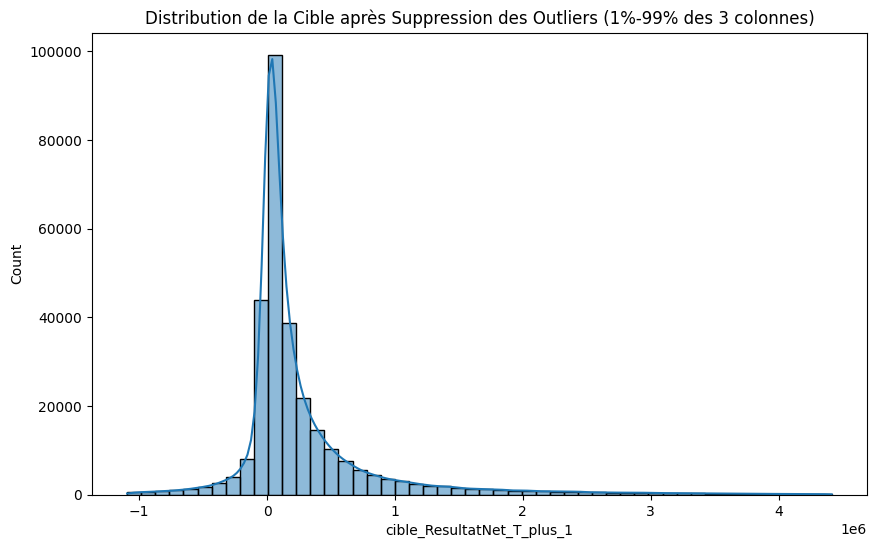

In [194]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Supposons que votre DataFrame principal est nommé df_final
df_pl = df_final.clone() 

# --- 1. COLONNES À FILTRER ---

COLONNES_OUTLIERS = [
    'HN_RésultatNet', 
    'cible_ResultatNet_T_plus_1', 
    'CJCK_TotalActifBrut'
]

LOWER_BOUND = 0.03  # 3%
UPPER_BOUND = 0.97  # 97%

# Initialiser la condition de filtre pour garder toutes les lignes
# Nous allons affiner cette condition pour chaque colonne
cumulative_condition = pl.lit(True) 

# --- 2. GESTION PRÉALABLE DES NaNs ET CRÉATION DE LA CONDITION ---

lignes_initiales = df_pl.shape[0]

# IMPORTANT : Remplir les NaNs temporairement par 0 dans les colonnes cibles 
# avant de calculer les quantiles (car NaN ne peut pas être trié).
# Nous n'allons pas modifier df_pl ici, mais utiliser une série temporaire pour le calcul.

for col in COLONNES_OUTLIERS:
    
    # 1. Préparation de la colonne (remplir les NaNs avec 0 pour le quantile)
    col_temp = df_pl.get_column(col).fill_null(0)
    
    # 2. Calcul des seuils (quantiles)
    q_lower = col_temp.quantile(LOWER_BOUND)
    q_upper = col_temp.quantile(UPPER_BOUND)
    
    print(f"[{col}] Seuil Inférieur (1%): {q_lower:.2f} | Seuil Supérieur (99%): {q_upper:.2f}")
    
    # 3. Création de la condition pour cette colonne
    # Le filtre doit être appliqué au DataFrame original (avec NaNs si elles n'ont pas été remplies)
    
    # Condition: Valeur >= q_lower ET Valeur <= q_upper
    col_condition = (pl.col(col).is_not_null()) & \
                    (pl.col(col) >= q_lower) & \
                    (pl.col(col) <= q_upper)
    
    # On ajoute la condition pour les valeurs qui étaient NaN. 
    # Si nous les avons remplies par 0, nous devons décider si 0 est dans la plage.
    # Dans un contexte financier où 0 est valide, il est préférable de filtrer seulement les extrêmes.
    
    # Mise à jour de la condition cumulative (le ET logique entre toutes les colonnes)
    cumulative_condition = cumulative_condition & col_condition

# --- 3. APPLICATION DU FILTRE ET VÉRIFICATION ---

df_pl_filtered = df_pl.filter(cumulative_condition)

lignes_finales = df_pl_filtered.shape[0]
lignes_supprimees = lignes_initiales - lignes_finales

print("-" * 50)
print(f"Lignes initiales : {lignes_initiales}")
print(f"Lignes supprimées : {lignes_supprimees} ({(lignes_supprimees / lignes_initiales) * 100:.2f}%)")
print(f"Lignes restantes : {lignes_finales}")

# --- 4. VISUALISATION DE LA CIBLE FILTRÉE (POUR L'EDA) ---

# Utilisez la nouvelle cible nettoyée pour la suite de l'analyse
TARGET_CLEANED = df_pl_filtered.select('cible_ResultatNet_T_plus_1').to_numpy().flatten()

plt.figure(figsize=(10, 6))
sns.histplot(TARGET_CLEANED, bins=50, kde=True)
plt.title(f"Distribution de la Cible après Suppression des Outliers (1%-99% des 3 colonnes)")
plt.xlabel("cible_ResultatNet_T_plus_1")
plt.show()

# Votre DataFrame nettoyé (sans les lignes extrêmes) est df_pl_filtered

In [195]:
df_pl_filtered.describe()

statistic,siren,date_cloture_exercice,CJCK_TotalActifBrut,HN_RésultatNet,DA_TresorerieActive,DL_DettesCourtTerme,AnneeClotureExercice,ratio_endettement,ratio_tresorerie,trancheEffectifsUniteLegale,activitePrincipaleUniteLegale,economieSocialeSolidaireUniteLegale,departement,caractereEmployeurSiege,anciennete_entreprise,cible_ResultatNet_T_plus_1
str,str,str,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,f64,f64
"""count""","""293859""","""293859""",293859.0,293859.0,293859.0,293859.0,293859.0,293859.0,293859.0,"""293859""","""293859""","""293859""","""293859""","""293859""",293859.0,293859.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""","""0""","""0""","""0""",0.0,0.0
"""mean""",null,"""2019-05-28 10:52:57.973109""",3.5220e6,248304.335974,761151.660728,2.4039e6,2018.495962,1.133483,0.476342,null,null,null,null,null,26.528277,272676.90068
"""std""",null,null,6.1094e6,530288.209661,7.2450e6,1.4808e7,1.708586,15.338736,11.785586,null,null,null,null,null,11.299087,580825.937341
"""min""","""006950059""","""2016-01-31""",47936.0,-1.028005e6,-2.1343e9,-2.1469e9,2016.0,-4928.235712,-56.381317,"""01""","""01.21Z""","""INCONNU""","""01""","""N""",2.0,-1.094272e6
"""25%""",null,"""2017-12-31""",430016.0,13130.0,18736.0,216131.0,2017.0,0.286409,0.023202,null,null,null,null,null,18.0,13134.0
"""50%""",null,"""2018-12-31""",1.223385e6,82308.0,99980.0,671584.0,2018.0,0.557823,0.067038,null,null,null,null,null,25.0,88063.0
"""75%""",null,"""2020-12-31""",3.738012e6,289467.0,387420.0,2.050397e6,2020.0,0.903181,0.204251,null,null,null,null,null,35.0,314647.0
"""max""","""998591507""","""2021-12-31""",5.3759484e7,3.986365e6,1.9165e9,2.1475e9,2021.0,4753.810054,5784.548208,"""53""","""96.09Z""","""O""","""97""","""O""",55.0,4.414535e6


In [197]:
# drop la colonne economieSocialeSolidaireUniteLegale

df_pl_filtered = df_pl_filtered.drop("economieSocialeSolidaireUniteLegale")

In [199]:
import polars as pl
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.model_selection import train_test_split

# --- 1. PRÉPARATION DES DONNÉES EN PANDAS ---

# Recharger les données de base (après nettoyage et consolidation)
# Ici, nous supposons que vous avez un DataFrame final nettoyé (data_consolidated ou df_final)
# IMPORTANT : Utiliser data_consolidated tel que défini dans la fonction load_and_transform_data

# Si vous utilisez le code de la V6/V7, vous devez exécuter load_and_transform_data une fois pour obtenir 'data'.
# data = load_and_transform_data('data/processed/sirene_infos_FINAL.parquet') # Déjà chargé
TARGET = 'cible_ResultatNet_T_plus_1'
COLS_TO_EXCLUDE = [TARGET, 'siren', 'date_cloture_exercice', 'AnneeClotureExercice']

X = data.drop(columns=COLS_TO_EXCLUDE)
y = data[TARGET]

# --- 2. SÉPARATION TRAIN/TEST (CRITIQUE POUR ÉVITER LE DATA LEAKAGE) ---

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# --- 3. DÉFINITION ET ENCODAGE ---

TARGET_ENCODING_COLS = ['departement', 'activitePrincipaleUniteLegale']
print(f"\nTarget Encoding en cours sur {TARGET_ENCODING_COLS}...")

# 1. Instancier l'Encoder
# TargetEncoder utilise par défaut la régularisation pour les catégories rares (M-Estimate)
target_encoder = ce.TargetEncoder(cols=TARGET_ENCODING_COLS, smoothing=1.0) 

# 2. FIT (Entraînement) UNIQUEMENT sur les données d'entraînement
# L'encoder apprend la moyenne de Y pour chaque département/activité dans X_train
X_train_encoded = target_encoder.fit_transform(X_train, y_train)

# 3. TRANSFORM (Application) sur les données de test
# L'encoder utilise les moyennes apprises pour encoder X_test
X_test_encoded = target_encoder.transform(X_test)

# --- 4. VÉRIFICATION ET ANALYSE (EDA) ---

print("\n--- Vérification des colonnes encodées (Doivent être numériques) ---")
print(X_train_encoded[TARGET_ENCODING_COLS].head())

# Visualisation pour justifier l'efficacité
plt.figure(figsize=(12, 5))
sns.boxplot(x=X_train_encoded['departement'], y=y_train)
plt.title("Boxplot du Résultat Net (Transformé) par Département Encoded")
plt.ylabel(f"Cible Transformée ({TARGET})")
plt.xlabel("Département (Encodé)")
plt.show()

# --- 5. INTÉGRATION À LA PROCHAINE ITÉRATION ---

print("\nCes colonnes encodées doivent être traitées comme des FEATURES NUMÉRIQUES dans le pipeline ML final.")

# Recomposez les jeux de données (X_train et X_test) avec les colonnes encodées
# Le reste des colonnes sera géré par l'OHE ou la Standardisation dans main.py

ModuleNotFoundError: No module named 'category_encoders'

In [198]:
# engistre moi tout ça dans un fichier parquet

PATH_OUTPUT_FINAL = "../Data/processed/sirene_infos_FINAL.parquet"

df_final.write_parquet(PATH_OUTPUT_FINAL)


In [187]:
df_final.schema


Schema([('siren', String),
        ('date_cloture_exercice', Date),
        ('CJCK_TotalActifBrut', Int32),
        ('HN_RésultatNet', Int32),
        ('DA_TresorerieActive', Int32),
        ('DL_DettesCourtTerme', Int32),
        ('AnneeClotureExercice', Int32),
        ('ratio_endettement', Float64),
        ('ratio_tresorerie', Float64),
        ('trancheEffectifsUniteLegale', String),
        ('activitePrincipaleUniteLegale', String),
        ('economieSocialeSolidaireUniteLegale', String),
        ('departement', String),
        ('caractereEmployeurSiege', String),
        ('anciennete_entreprise', Int32),
        ('cible_ResultatNet_T_plus_1', Int32)])